Problem Statement : Customer churn prediction refers to the process of identifying customers who are likely to stop using a product or service in the near future. It is a valuable predictive analytics technique used by businesses to forecast customer behavior and take proactive measures to retain customers.

In [15]:
# Import necessary libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from matplotlib import pyplot as plt
import scipy
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from collections import Counter
from imblearn.combine import SMOTEENN
plt.style.use('default')
import warnings
warnings.filterwarnings("ignore")

Kaggle Dataset Link : https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [17]:
# Load the data.
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display the first 10 rows of the dataframe.
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [18]:
# Check the shape of the dataframe.
df.shape

(7043, 21)

In [19]:
#print concise summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [20]:
#check for missing values
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [21]:
#check for duplicate records
df[df.duplicated()].shape[0]

0

In [22]:
#since customerId is not required for prediction so drop it
df.drop('customerID',axis=1,inplace=True)

In [23]:
#since total changes is having numerical value but dtype is object to change it into numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

In [24]:
#print last 5 records of the  dataset
df.tail(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes
7042,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.50,No


**2. Data Analysis**

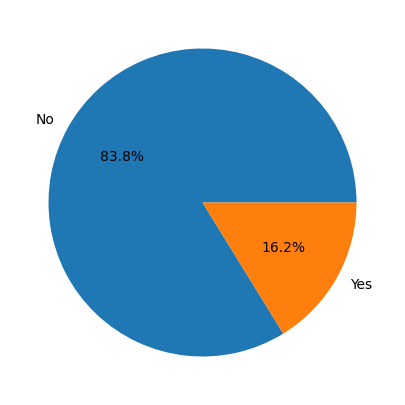

In [25]:
#pie chart to count senior citizen
plt.figure(figsize=(10,5))
plt.pie(df["SeniorCitizen"].value_counts(),autopct="%.1f%%",labels=["No","Yes"])
plt.show()

as we can see 83.8 % of the customers are senior citizen and only 16.2% are adult customer.

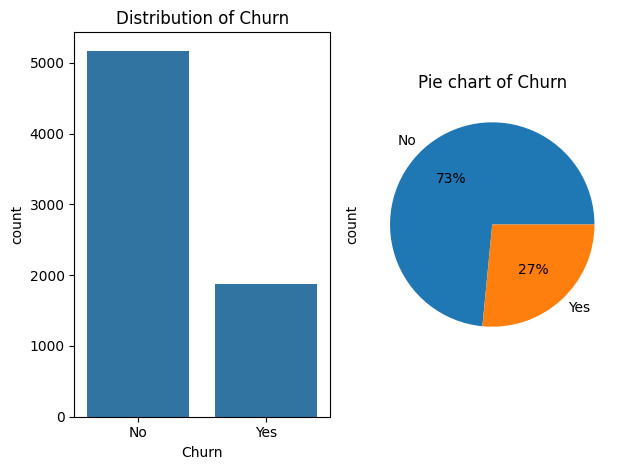

In [26]:
#check the distibution of churn class
plt.subplot(121)
sns.countplot(data=df,x="Churn")
plt.title("Distribution of Churn")
plt.subplot(122)
df['Churn'].value_counts().plot(kind='pie',autopct="%1.f%%",labels=['No','Yes'])
plt.title('Pie chart of Churn')
plt.tight_layout()
plt.show()

In [27]:
#perentage of each class sample distribution
print("Customer Churn : {}%".format(np.round((len(df[df["Churn"]=="Yes"])/len(df)*100),decimals=2)))
print("Customer Not Churn : {}%".format(np.round((len(df[df["Churn"]=="No"])/len(df)*100),decimals=2)))

Customer Churn : 26.54%
Customer Not Churn : 73.46%


Since our dataset is highly imbalance we need to balance before fitting it into model

In [28]:
#how much loss we are having because of customer churn
churn_customers=df[df["Churn"]=="Yes"]
loss=churn_customers["TotalCharges"].sum()
total_revenue=df["TotalCharges"].sum()
print("We have lost arround {}$ due to customer churn".format(loss))
print("We have lost arround {} percentage of revengue due to customer churn".format(np.round(loss/total_revenue*100,decimals=2)))

We have lost arround 2862926.9$ due to customer churn
We have lost arround 17.83 percentage of revengue due to customer churn


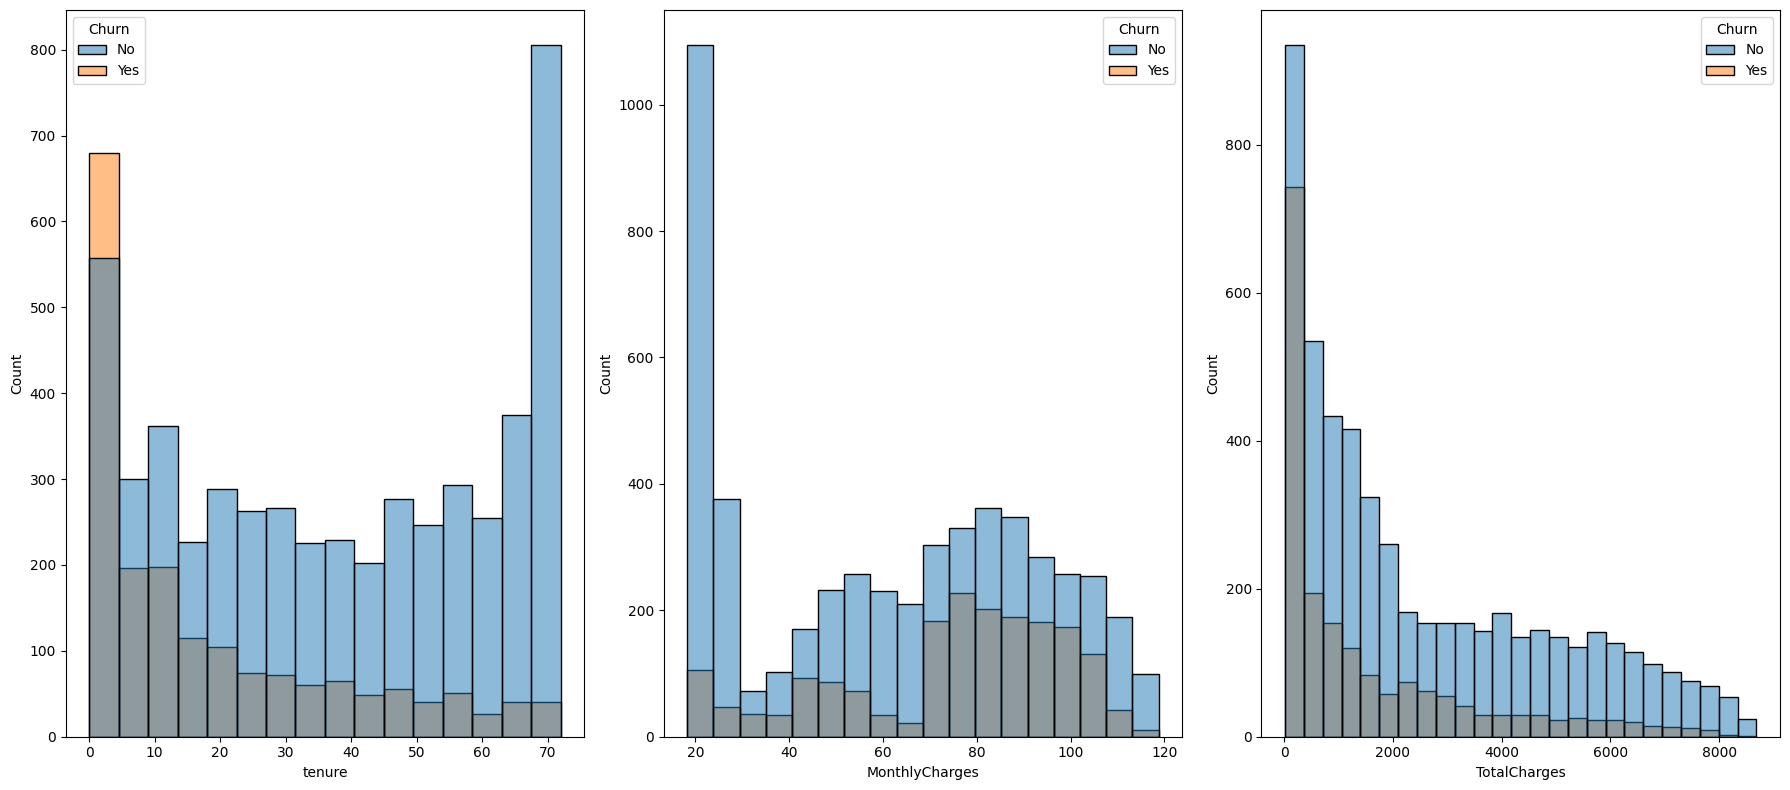

In [29]:
#plot numerical features with histogram
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(18,8))
axes=axs.flatten()
num_columns=['tenure', 'MonthlyCharges', 'TotalCharges']
for i,col in enumerate(num_columns):
  if(col!='SeniorCitizen'):
    sns.histplot(x=col,data=df,hue='Churn',ax=axes[i])
fig.tight_layout()
plt.show()

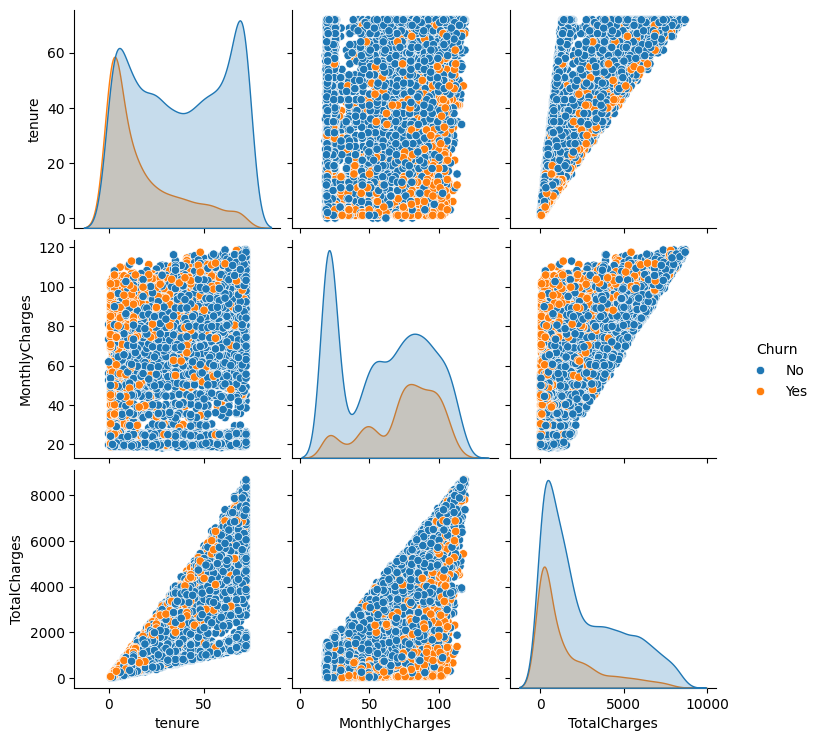

In [31]:
sns.pairplot(df.drop(columns="SeniorCitizen"),hue="Churn",kind="scatter")
plt.show()

# 3. Univariate Analysis

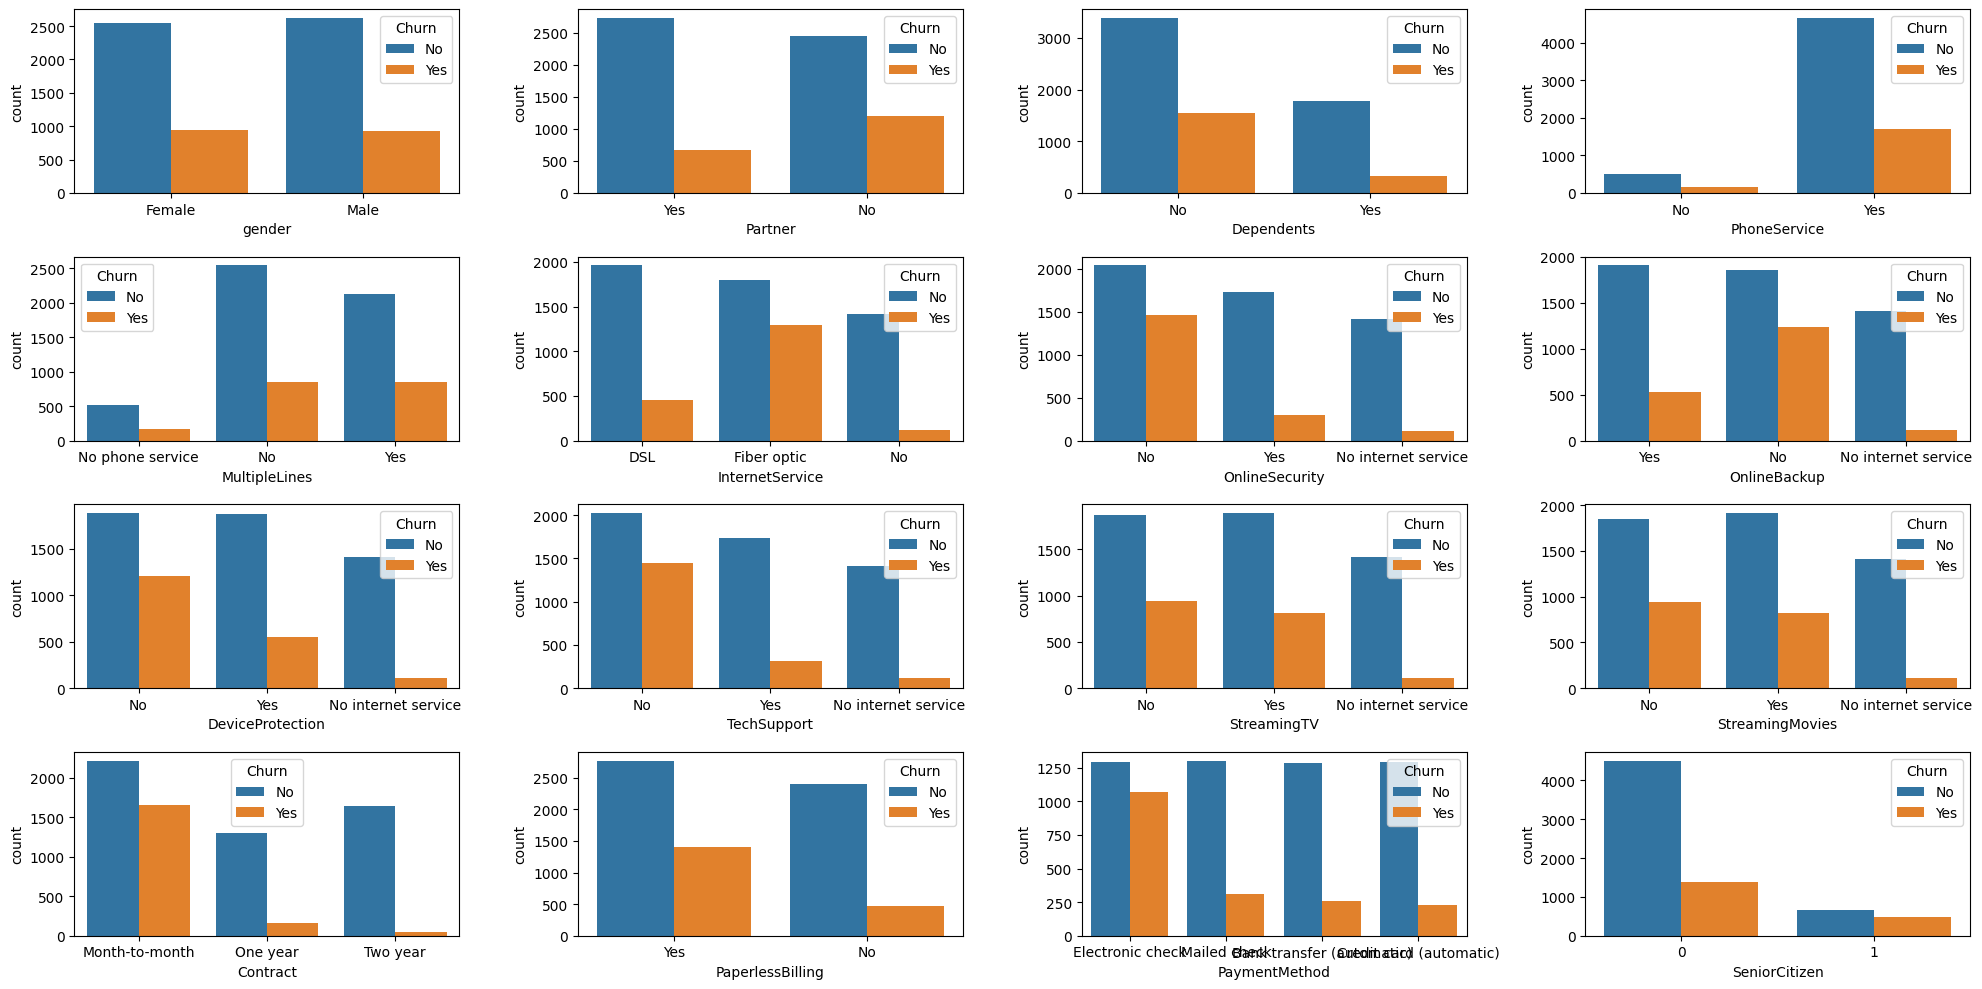

In [32]:
#plot cateogrical features :
cat_features=list(df.select_dtypes(include='object').columns)
cat_features.remove('Churn')
cat_features.append('SeniorCitizen')

fig,axs=plt.subplots(nrows=4,ncols=4,figsize=(20,10))
axes=axs.flatten()
for i,col in enumerate(cat_features):
    sns.countplot(x=col,hue="Churn",data=df,ax=axes[i])
#adjust spacing between subplots
fig.tight_layout()
plt.show()

In [34]:
#check for null values
df.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [35]:
df["TotalCharges"].fillna(df["TotalCharges"].mean(),inplace=True)

In [36]:
df.isnull().sum().sum()

0

In [37]:
#encoding categorical values into numeric using label encoder
encoder=LabelEncoder()
for feature in df.select_dtypes(include='object').columns:
    df[feature]=encoder.fit_transform(df[feature])

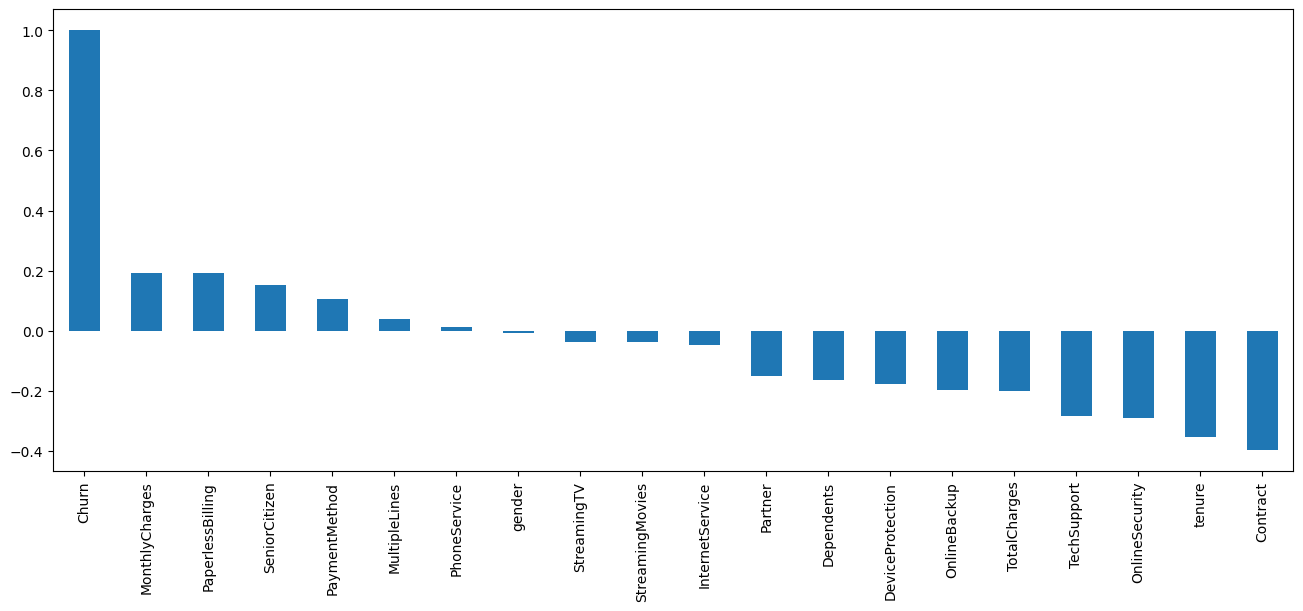

In [38]:
#get correlation of churn with other variables
plt.figure(figsize=(16,6))
df.corr()["Churn"].sort_values(ascending=False).plot(kind="bar")
plt.show()

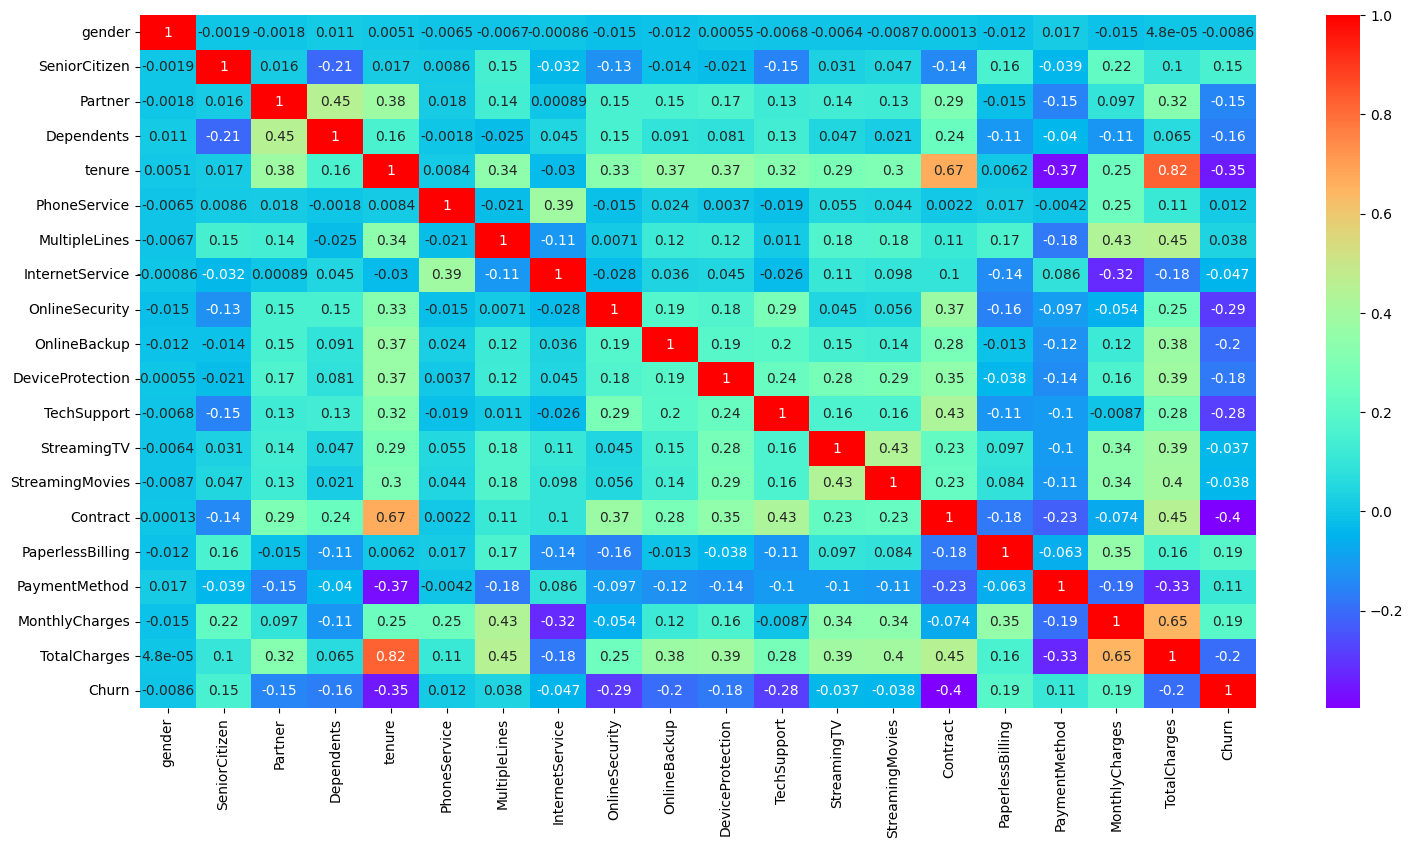

In [39]:
plt.figure(figsize=(18,9))
sns.heatmap(df.corr(),annot=True,cmap="rainbow")
plt.show()

since we are using ensemble methods for model building so there is no need of feature scaling as its prediction is based on creating multiple decision tree

In [40]:
#seperating independent variables and target variable
x=df.drop("Churn",axis=1)
y=df["Churn"]

# Feature Selection
selecting only 10 features which has higher correlation with churn

In [41]:
select_feature=SelectKBest(k=10) #no of features to be select
select_feature.fit(x,y)

SelectKBest()

In [42]:
#Top 10 high correlated features
select_feature.get_feature_names_out()

array(['Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges'], dtype=object)

In [43]:
x=x[select_feature.get_feature_names_out()]

In [45]:
x.shape #according to the feature selection we have selected 10 top features out of 19 features

(7043, 10)

split data into training and validation set in 80:20 ratio

In [46]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [47]:
#its imbalance dataset
y.value_counts()

,count
Churn,
0,5174
1,1869


In [48]:
def evaluate_model_performance(model,test_data):
    prediction=model.predict(test_data)
    #print("Training Accurary : ",model.score(x_train,y_train))
    print("Validation Accurary : {:.2f} %".format(accuracy_score(y_test,prediction)))
    print("Precision Score : {:.2f} %".format(precision_score(y_test,prediction)))
    print("Recall Score : {:.2f} %".format(recall_score(y_test,prediction)))
    print("F1 Score : {:.2f} %".format(f1_score(y_test,prediction)))
    print(classification_report(y_test,prediction))

In [49]:
#Random Forest Model without balancing dataset and without hyper paramter tuning
rand_forest=RandomForestClassifier()
rand_forest.fit(x_train,y_train)

RandomForestClassifier()

In [50]:
#measure the performance of random forest model
evaluate_model_performance(rand_forest,x_test)

Validation Accurary : 0.79 %
Precision Score : 0.64 %
Recall Score : 0.47 %
F1 Score : 0.54 %
              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1036
           1       0.64      0.47      0.54       373

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



In [51]:
#GradientBoostingClassifier without balancing dataset and without hyper paramter tuning
gbc_model=GradientBoostingClassifier( )
gbc_model.fit(x_train,y_train)

GradientBoostingClassifier()

In [52]:
#measure the performance of GradientBoostingClassifier
evaluate_model_performance(gbc_model,x_test)

Validation Accurary : 0.81 %
Precision Score : 0.67 %
Recall Score : 0.53 %
F1 Score : 0.59 %
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1036
           1       0.67      0.53      0.59       373

    accuracy                           0.81      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

